## <p style="background-color:skyblue; font-family:newtimeroman; font-size:220%; text-align:center; border-radius: 12px 50px;">Sentiment Analysis NLP</p>

### Importing Required Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import string
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from tqdm import tqdm
import os
import nltk
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D
                         )
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

from sklearn.metrics import (
precision_score,
recall_score,
f1_score,
classification_report,    
accuracy_score
)


**Natural Language Processing or NLP** is a branch of Artificial Intelligence which deal with bridging the machines understanding humans in their Natural Language. Natural Language can be in form of text or sound, which are used for humans to communicate each other. NLP can enable humans to communicate to machines in a natural way.



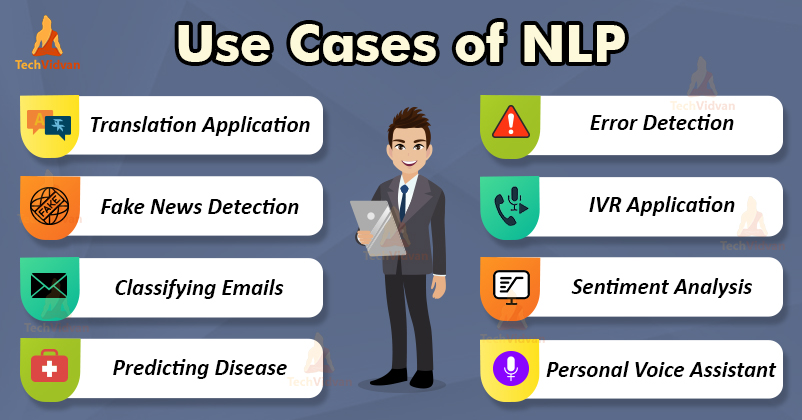

**Text Classification** is a process involved in Sentiment Analysis. It is classification of peoples opinion or expressions into different sentiments. Sentiments include Positive, Neutral, and Negative, Review Ratings and Happy, Sad. Sentiment Analysis can be done on different consumer centered industries to analyse people's opinion on a particular product or subject.

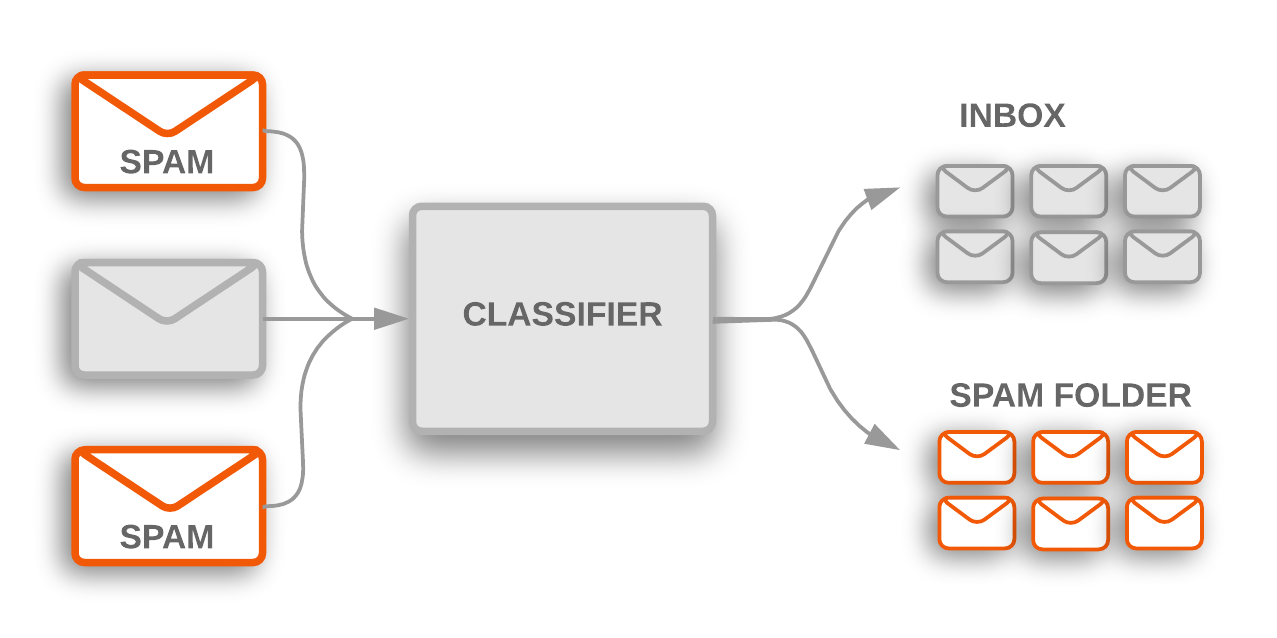

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Table of Content</p>

* [1. Loading Data 💎](#1)
* [2. EDA 📊](#2)
* [3. Data Preprocessing ⚙️](#3)
    * [3.1 Cleaning the corpus 🛠](#3.1)
    * [3.2 Stemming 🛠](#3.2)
    * [3.3 All together 🛠](#3.3)
    * [3.4 Target encoding 🛠](#3.4)
* [4. Tokens visualization 📊](#4)
* [5. Vectorization](#5)
    * [5.1 Tunning CountVectorizer](#5.1)
    * [5.2 TF-IDF](#5.2)
    * [5.3 Word Embeddings: GloVe](#5.3)
* [6. Modeling](#6)
    * [6.1 Naive Bayes DTM](#6.1)
    * [6.2 Naive Bayes TF-IDF](#6.2)
    * [6.3 XGBoost](#6.3)
* [7. LSTM](#7)
* [8. BERT](#8)
* [9. NLP: Disaster tweets](#9)
    * [9.1 EDA](#9.1)
    * [9.2 Data preprocessing](#9.2)
    * [9.3 WordCloud](#9.3)
    * [9.4 Modeling](#9.4)
    * [9.5 GloVe - LSTM](#9.5)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Loading Data 💎</p>

Just load the dataset and global variables for colors and so on.

In [2]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [3]:
df=pd.read_csv("../input/sms-spam-collection-dataset/spam.csv",encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df=df.dropna(how="any",axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.columns=['target','message']
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df["message_len"]=df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [7]:
df["message_len"]

0       20
1        6
2       28
3       11
4       13
        ..
5567    30
5568     8
5569    10
5570    26
5571     6
Name: message_len, Length: 5572, dtype: int64

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. EDA 📊</p>

Now we are going to take a look about the target distribution and the messages length.

In [8]:
balance_counts=df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [9]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

As we can see, the classes are imbalanced, so we can consider using some kind of resampling. We will study later. Anyway, it doesn't seem to be necessary.

In [10]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

As we can see, the `ham` message length tend to be lower than `spam` message length.

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Data Pre-processing 🛠</p>

Now we are going to engineering the data to make it easier for the model to clasiffy.

This section is very important to reduce the dimensions of the problem.

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.1 Cleaning the corpus 🛠</p>

In [11]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
df['message_clean']=df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some examples removing stopwords are:

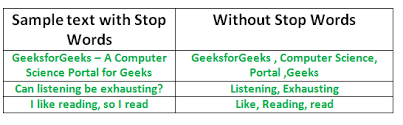

In [13]:
stop_words=stopwords.words('english')
more_stopwords=['u','im','c']
stop_words=stop_words+more_stopwords


def remove_stopwords(text):
    text=' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


<a id='3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.2 Stemming 🛠</p>

### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes*. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

**Stemming** usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

**Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

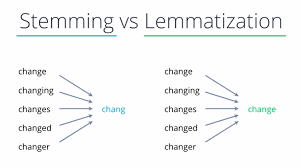

As far as the meaning of the words is not important for this study, we will focus on stemming rather than lemmatization.

### Stemming algorithms

There are several stemming algorithms implemented in NLTK Python library:
1. **PorterStemmer** uses *Suffix Stripping* to produce stems. **PorterStemmer is known for its simplicity and speed**. Notice how the PorterStemmer is giving the root (stem) of the word "cats" by simply removing the 's' after cat. This is a suffix added to cat to make it plural. But if you look at 'trouble', 'troubling' and 'troubled' they are stemmed to 'trouble' because *PorterStemmer algorithm does not follow linguistics rather a set of 05 rules for different cases that are applied in phases (step by step) to generate stems*. This is the reason why PorterStemmer does not often generate stems that are actual English words. It does not keep a lookup table for actual stems of the word but applies algorithmic rules to generate stems. It uses the rules to decide whether it is wise to strip a suffix.
2. One can generate its own set of rules for any language that is why Python nltk introduced **SnowballStemmers** that are used to create non-English Stemmers!
3. **LancasterStemmer** (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. One table containing about 120 rules indexed by the last letter of a suffix. On each iteration, it tries to find an applicable rule by the last character of the word. Each rule specifies either a deletion or replacement of an ending. If there is no such rule, it terminates. It also terminates if a word starts with a vowel and there are only two letters left or if a word starts with a consonant and there are only three characters left. Otherwise, the rule is applied, and the process repeats.

In [14]:
stemmer=nltk.SnowballStemmer("english")
def stem_text(text):
    text=' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [15]:
df['message_clean']=df['message_clean'].apply(stem_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.3 All together 🛠</p>

In [16]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

<a id='3.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.4 Target encoding 🛠</p>

In [17]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
le.fit(df['target'])

df['target_encoded']=le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Tokens visualization 📊</p>

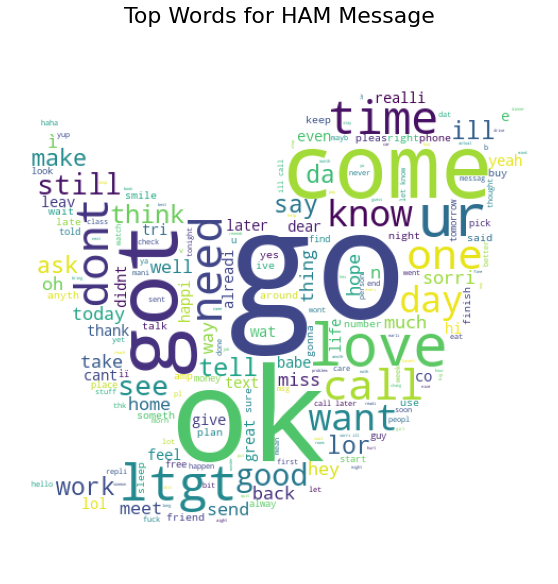

In [18]:
twitter_mask=np.array(Image.open("../input/masksforwordclouds/twitter_mask3.jpg"))

wc=WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask
)

wc.generate(' '.join(text for text in df.loc[df['target']=='ham','message_clean']))

plt.figure(figsize=(18,10))
plt.title('Top Words for HAM Message',
         fontdict={ 'size':22, 'verticalalignment':'bottom'} )
plt.imshow(wc)
plt.axis('off')
plt.show()

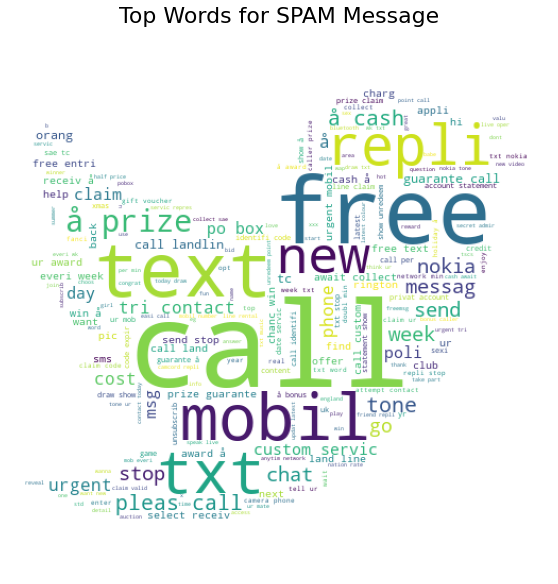

In [19]:
twitter_mask=np.array(Image.open('../input/masksforwordclouds/twitter_mask3.jpg'))
wc=WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask
)

wc.generate(' '.join(text for text in df.loc[df['target']=='spam','message_clean']))

plt.figure(figsize=(18,10))
plt.title('Top Words for SPAM Message',
         fontdict={ 'size':22, 'verticalalignment':'bottom'} )
plt.imshow(wc)
plt.axis('off')
plt.show()


<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Vectorization</p>

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:



Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.



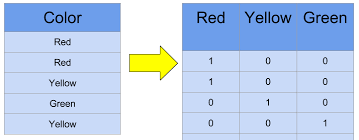!

In [20]:
x=df['message_clean']
y=df['target']

print(len(x),len(y))

5572 5572


In [21]:
# Splitting Data into Train & Test

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

4179 4179
1393 1393


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [23]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm=vect.transform(x_train)
x_test_dtm=vect.transform(x_test)

<a id='5.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">5.1 Tunning CountVectorizer</p>

CountVectorizer has a few parameters you should know.

1. **stop_words**: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.

2. **ngram_range**: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1). In a recent project where I modeled job postings online, I found that including 2-grams as features boosted my model’s predictive power significantly. This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long.

3. **min_df, max_df**: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).

4. **max_features**: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else. 

You would set these parameters when initializing your CountVectorizer object as shown below.

In [24]:
vect_tunned=CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=0.1,max_df=0.7,max_features=100)

<a id='5.2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">5.2 TF-IDF</p>

In information retrieval, tf–idf, **TF-IDF**, or TFIDF, **short for term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. 

**tf–idf** is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.


In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x5717 sparse matrix of type '<class 'numpy.float64'>'
	with 32431 stored elements in Compressed Sparse Row format>

<a id='5.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">5.3 Word Embeddings: GloVe</p>

In [26]:
texts = df['message_clean']
target = df['target_encoded']

We need to perform **tokenization** - the processing of segmenting text into sentences of words. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

In [27]:
# Calculate the Length of vocabulary
word_tokenizer=Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length=len(word_tokenizer.word_index)+1
vocab_length

6769

### Pad_sequences

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

```python
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
```

This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

```python
>>> sequence = [[1], [2, 3], [4, 5, 6]]
>>> tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
array([[1, 0, 0],
       [2, 3, 0],
       [4, 5, 6]], dtype=int32)
```

In [28]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   2, 3199,  276, ...,    0,    0,    0],
       [   8,  239,  532, ...,    0,    0,    0],
       [   9,  361,  591, ...,    0,    0,    0],
       ...,
       [6767, 1007, 6768, ...,    0,    0,    0],
       [ 139, 1257, 1612, ...,    0,    0,    0],
       [1998,  382,  171, ...,    0,    0,    0]], dtype=int32)

### GloVe

GloVe method is built on an important idea,

> You can derive semantic relationships between words from the co-occurrence matrix.

To obtain a vector representation for words we can use an unsupervised learning algorithm called **GloVe (Global Vectors for Word Representation)**, which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space.

Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

In [29]:
embedding_dictionary=dict()
embedding_dim=100

# Load  Glove 100 D embeddings
with open('../input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records=line.split()
        word=records[0]
        vector_dimensions=np.asarray(records[1:],dtype='float32')
        embedding_dictionary[word]=vector_dimensions
        
#embedding_dictionary

In [30]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">6. Modeling</p>

In [31]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [32]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

<a id='6.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">6.1 Naive Bayes DTM</p>

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

![](https://www.kdnuggets.com/wp-content/uploads/bayes-nagesh-1.jpg)

In [33]:
# Make class and probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [34]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9784637473079684


In [35]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9745842444094048

<a id='6.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">6.2 Naive Bayes</p>

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

In [37]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9597989949748744


<a id='6.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">6.3 XGBoost</p>

In [38]:
import xgboost as xgb
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])


In [39]:
""" #Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class)) """

" #Fit the pipeline with the data\npipe.fit(x_train, y_train)\n\ny_pred_class = pipe.predict(x_test)\ny_pred_train = pipe.predict(x_train)\n\nprint('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))\nprint('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))\n\nconf_matrix(metrics.confusion_matrix(y_test, y_pred_class)) "

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">7. LSTM</p>

In [40]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

In [41]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           676900    
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 160)           115840    
_________________________________________________________________
global_max_pooling1d (Global (None, 160)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 160)               640       
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 80)                12880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0

In [42]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 10,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
131/131 [==============================] - 112s 808ms/step - loss: 0.5109 - accuracy: 0.7694 - val_loss: 0.2730 - val_accuracy: 0.9182

Epoch 00001: val_loss improved from inf to 0.27299, saving model to model.h5
Epoch 2/10
131/131 [==============================] - 105s 802ms/step - loss: 0.1891 - accuracy: 0.9390 - val_loss: 0.1371 - val_accuracy: 0.9684

Epoch 00002: val_loss improved from 0.27299 to 0.13710, saving model to model.h5
Epoch 3/10
131/131 [==============================] - 107s 816ms/step - loss: 0.1384 - accuracy: 0.9585 - val_loss: 0.0906 - val_accuracy: 0.9698

Epoch 00003: val_loss improved from 0.13710 to 0.09059, saving model to model.h5
Epoch 4/10
131/131 [==============================] - 106s 811ms/step - loss: 0.1062 - accuracy: 0.9702 - val_loss: 0.0787 - val_accuracy: 0.9813

Epoch 00004: val_loss improved from 0.09059 to 0.07866, saving model to model.h5
Epoch 5/10
131/131 [==============================] - 108s 821ms/step - loss: 0.0982 - accur

In [43]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

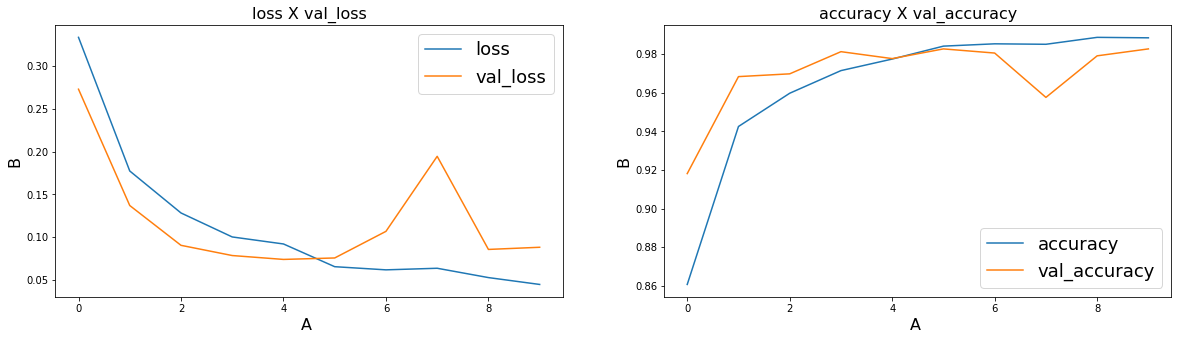

In [44]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [45]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

<a id='8'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">8. BERT</p>

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.


BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

Ref: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

In [46]:
# install transformers
!pip install transformers

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [48]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [49]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [50]:
texts = df['message_clean']
target = df['target_encoded']
train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2110: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [51]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [52]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [53]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 32)           24608       tf_bert_model[0][1]          

In [54]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=1,
    batch_size=10
)

446/446 [==============================] - 84s 147ms/step - loss: 0.3112 - accuracy: 0.8629 - val_loss: 0.0588 - val_accuracy: 0.9785


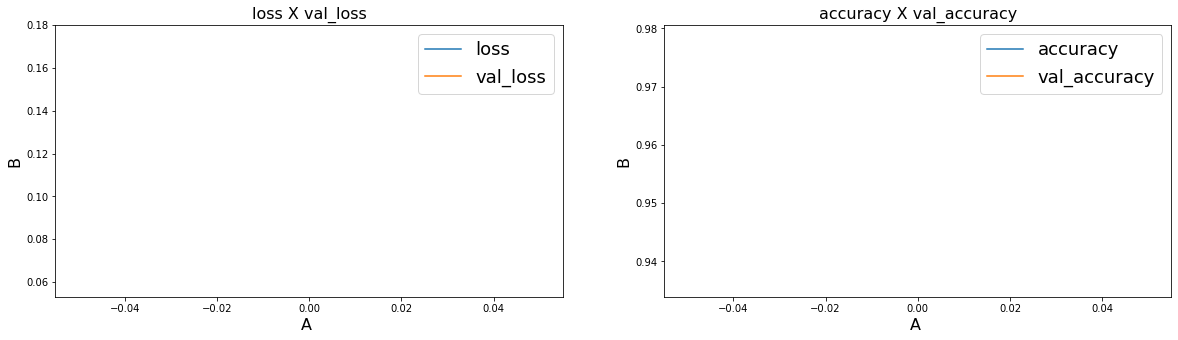

In [55]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

<a id='9'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">9. NLP: Disaster Tweets</p>

In [56]:
df = pd.read_csv("../input/nlpgettingstarted/train.csv", encoding="latin-1")
test_df = pd.read_csv("../input/nlpgettingstarted/test.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))

df.head()

,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


<a id='9.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">9.1 EDA</p>

In [57]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271])

In [58]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [59]:
disaster_df = df[df['target'] == 1]['text_len'].value_counts().sort_index()
fake_df = df[df['target'] == 0]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=disaster_df.index,
    y=disaster_df.values,
    name='Real disaster',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=fake_df.index,
    y=fake_df.values,
    name='Fake',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.show()

<a id='9.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">9.2 Data preprocessing</p>

In [60]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [61]:
# Test emoji removal
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [62]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

In [63]:
test_df['text_clean'] = test_df['text'].apply(preprocess_data)

df['text_clean'] = df['text'].apply(preprocess_data)
df.head()

,id,text,target,text_len,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


<a id='9.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">9.3 WordCloud</p>

In [64]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text_clean'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Real disasters

In [65]:
corpus_disaster_tweets = create_corpus_df(df, 1)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('fire', 266),
 ('bomb', 179),
 ('kill', 158),
 ('news', 132),
 ('via', 121),
 ('flood', 120),
 ('disast', 116),
 ('california', 115),
 ('crash', 110),
 ('suicid', 110)]

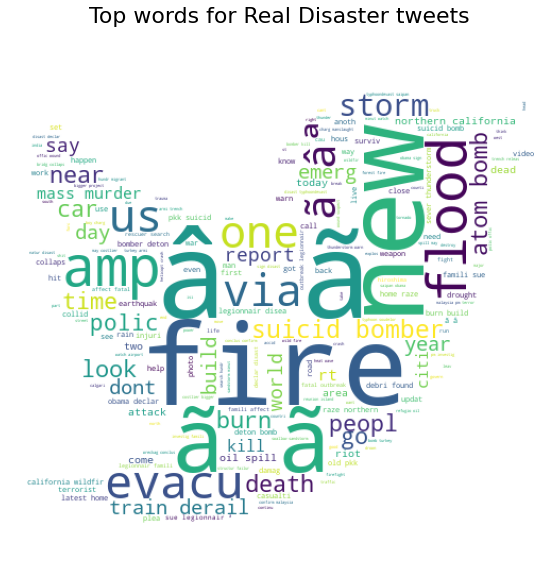

In [66]:
twitter_mask = np.array(Image.open('../input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Real Disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

### Fake disasters

In [67]:
corpus_disaster_tweets = create_corpus_df(df, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 306),
 ('get', 222),
 ('amp', 192),
 ('new', 168),
 ('go', 142),
 ('dont', 139),
 ('one', 134),
 ('bodi', 116),
 ('love', 115),
 ('bag', 108)]

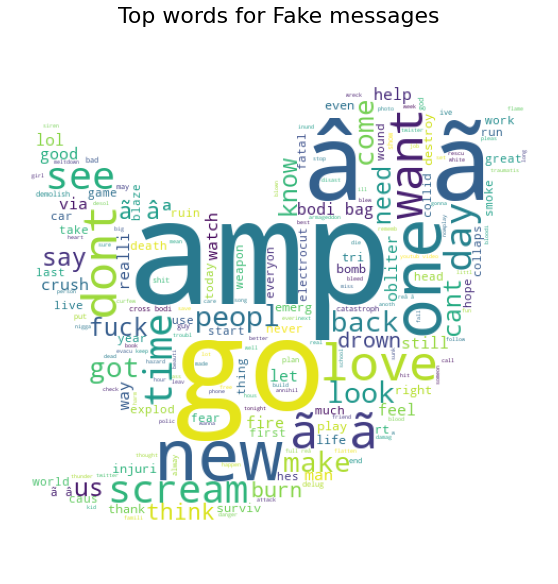

In [68]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<a id='9.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">9.4 Modeling</p>

In [69]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['text_clean']
y = df['target']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [70]:
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
    ))
])
from sklearn import metrics

# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

Train: 0.8567174636538798
Test: 0.7725840336134454


<a id='9.5'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">9.5 GloVe - LSTM</p>

Thanks to: https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm

We are going to use **LSTM (long short-term memory)** model .

In [71]:
train_tweets = df['text_clean'].values
test_tweets = test_df['text_clean'].values
train_target = df['target'].values

We need to perform **tokenization** - the processing of segmenting text into sentences of words. In the process we throw away punctuation and extra symbols too. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing

In [72]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13704

In [73]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

### Pad_sequences

In [74]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3635,  467,  201, ...,    0,    0,    0],
       [ 136,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1807, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2637, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]], dtype=int32)

### GloVe

To obtain a vector representation for words we can use an unsupervised learning algorithm called **GloVe (Global Vectors for Word Representation)**, which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

In [75]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

### Model LSTM

In [76]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [77]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
179/179 [==============================] - 54s 268ms/step - loss: 1.1014 - accuracy: 0.4822 - val_loss: 0.6602 - val_accuracy: 0.5993

Epoch 00001: val_loss improved from inf to 0.66017, saving model to model.h5
Epoch 2/7
179/179 [==============================] - 50s 279ms/step - loss: 0.6482 - accuracy: 0.6399 - val_loss: 0.5637 - val_accuracy: 0.7458

Epoch 00002: val_loss improved from 0.66017 to 0.56372, saving model to model.h5
Epoch 3/7
179/179 [==============================] - 48s 267ms/step - loss: 0.5678 - accuracy: 0.7212 - val_loss: 0.4991 - val_accuracy: 0.7815

Epoch 00003: val_loss improved from 0.56372 to 0.49907, saving model to model.h5
Epoch 4/7
179/179 [==============================] - 50s 278ms/step - loss: 0.5276 - accuracy: 0.7672 - val_loss: 0.4762 - val_accuracy: 0.7915

Epoch 00004: val_loss improved from 0.49907 to 0.47615, saving model to model.h5
Epoch 5/7
179/179 [==============================] - 47s 262ms/step - loss: 0.4766 - accuracy: 0.804

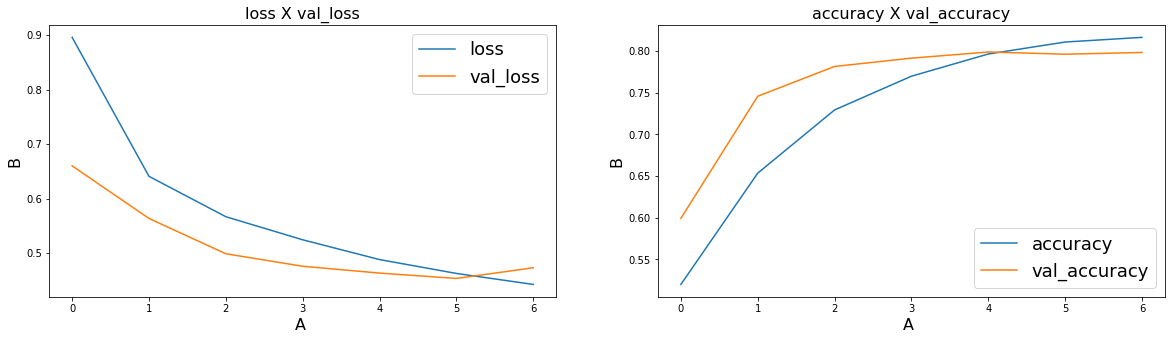

In [78]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [79]:
preds = model.predict_classes(X_test)
show_metrics(preds, y_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



F1-score:  0.7525773195876289
Precision:  0.7113276492082826
Recall:  0.79890560875513
Acuracy:  0.7983193277310925
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1173
           1       0.71      0.80      0.75       731

    accuracy                           0.80      1904
   macro avg       0.79      0.80      0.79      1904
weighted avg       0.81      0.80      0.80      1904

